In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
import sys
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../input/haberman-survival/data.csv')

In [3]:
data.head()
# (306,4)

,Age,Year,AxillaryNode,Survival
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [4]:
#nor_data = (data -np.min(data))/(np.max(data)-np.min(data)).values

In [5]:
age = data.Age.values
year = data.Year.values
node = data.AxillaryNode.values
y = data.Survival.values

In [6]:
def mean(data):
    return sum(data) / len(data)

In [7]:
def dot(v,w): 
    return sum(v_i * w_i for v_i, w_i in zip (v,w))

In [8]:
def sum_of_squares(v):
    return dot(v,v)

In [9]:
def de_mean(x) : 
    x_bar = mean(x) 
    return [x_i - x_bar for x_i in x]

In [10]:
def variance(x): 
    n = len(x) 
    deviations = de_mean(x) 
    return sum_of_squares(deviations) / (n-1)

In [11]:
def standard_deviation(x) : 
    return math.sqrt(variance(x))

In [12]:
def covariance(x,y):
    n = len(x) 
    return dot(de_mean(x), de_mean(y)) / (n-1)

In [13]:
p_value = []

In [14]:
def correlation(x,y):
    stdev_x = standard_deviation(x);
    stdev_y = standard_deviation(y);
    
    if stdev_x > 0 and stdev_y > 0: 
        p = covariance(x,y) / (stdev_x * stdev_y)
        p_value.append(p)
        return p
    else : 
        return 0

In [15]:
def feature_map(x, y):
    f_map = []
    p = correlation(x, y)
    for i in x:
        i **= p
        f_map.append(i)
    return f_map

In [16]:
kernel_age = feature_map(age, y)
kernel_year = feature_map(year, y)
kernel_node = feature_map(node, y)

In [17]:
kernel_array = np.array([kernel_age, kernel_year, kernel_node])
featured_data = pd.DataFrame(kernel_array)
print(featured_data)

        0         1         2         3         4         5         6    \
0  1.259352  1.259352  1.259352  1.262155  1.262155  1.267517  1.267517   
1  0.980365  0.980513  0.980293  0.980745  0.980293  0.980825  0.980667   
2  1.000000  1.357630  0.000000  1.212762  1.470792  1.898002  0.000000   

        7         8         9    ...       296       297       298       299  \
0  1.270085  1.270085  1.270085  ...  1.336365  1.337616  1.337616  1.338850   
1  0.980745  0.980221  0.980825  ...  0.980151  0.980513  0.980082  0.980293   
2  0.000000  1.843158  2.576784  ...  1.357630  0.000000  0.000000  1.357630   

        300       301       302       303       304       305  
0  1.338850  1.340069  1.341273  1.342462  1.343637  1.349309  
1  0.980439  0.980513  0.980151  0.980293  0.980293  0.980825  
2  0.000000  1.000000  0.000000  1.357630  1.000000  1.212762  

[3 rows x 306 columns]


In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(featured_data.T, y, test_size=0.15, random_state=42)

x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

In [19]:
# return value in range 0 to 1
def sigmoid(z):
    y_pred = 1/(1+np.exp(-z))
    
    return y_pred

In [20]:
weight_list = []
costs = []

In [21]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    weight_list.append(w)
    return w, b

In [22]:
def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    
    
    for i in range (number_of_iterarion):
        z = np.dot(w.T,x_train) + b # T for transpose to align matrices
        y_pred = sigmoid(z)
        loss = -y_train*np.log(y_pred)-(1-y_train)*np.log(1-y_pred)
        cost = (np.sum(loss))/x_train.shape[1] # x_train.shape[1] is for num of columns

        # gradient weight
        weight = (np.dot(x_train,((y_pred - y_train).T)))/x_train.shape[1]
        
        # gradient bias
        bias = np.sum(y_pred - y_train)/x_train.shape[1]

        w = w - learning_rate * weight
        b = b - learning_rate * bias
        
        costs.append(cost)
        weight_list.append(weight)
        
        if i % 10 == 0:            
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(costs)
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return w, b

In [23]:
def predict(w,b,x_test):
    z = sigmoid(np.dot(w.T,x_test)+b)
    y_pred = np.zeros((1,x_test.shape[1])) # zero matrix size of columns
    
    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            y_pred[0,i] = 0
        else:
            y_pred[0,i] = 1
    return y_pred

In [24]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate, num_iterations):
    a = x_train.shape[0]

    w, b = initialize_weights_and_bias(a)
    w, b = update(w, b, x_train, y_train, learning_rate, num_iterations)
    
    y_pred_test = predict(w, b, x_test)
    y_pred_train = predict(w, b, x_train)
    
    # np.abs to make the result 0 or 1
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

Cost after iteration 0: 0.668016
Cost after iteration 10: -4.464500
Cost after iteration 20: nan
Cost after iteration 30: nan
Cost after iteration 40: nan


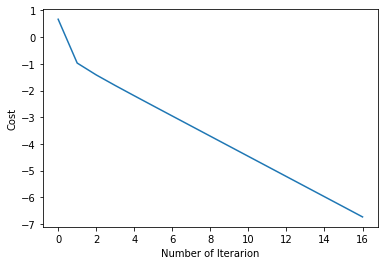

train accuracy: 73.84615384615384 %
test accuracy: 71.73913043478261 %


In [25]:
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 1, num_iterations = 50)

In [26]:
def write_txt_list(list, fname, sep) :
    file = open(fname, 'w')
    vstr = ''

    for a in list :
        for b in a  :     
            vstr = vstr + str(b) + sep
        vstr = vstr.rstrip(sep)
        vstr = vstr + '\n'

    file.writelines(vstr)
    file.close()

In [27]:
write_txt_list(weight_list, 'weight3.txt', sep=',')
print(p_value)

[0.0677989332248903, -0.004768180171165573, 0.2782967169197935]
